In [1]:
from fmp_python.fmp import FMP
import pandas as pd
from dotenv import load_dotenv
import os
from datetime import datetime

load_dotenv()
FMP_API_KEY = os.getenv("FMP_API_KEY")
fmp = FMP(output_format='pandas',api_key=FMP_API_KEY)

In [2]:
ms = fmp.get_historical_price("MSFT")
fb = fmp.get_historical_price("META")

ms['date'] = pd.to_datetime(ms['date'],yearfirst=True)
fb['date'] = pd.to_datetime(fb['date'],yearfirst=True)

ms = ms.set_index('date')
fb = fb.set_index('date')

fb = fb.sort_index()
ms = ms.sort_index()


In [3]:
# loc[] uses index and column name
# iloc[] uses indexes only

In [4]:
fb['price_diff'] = fb['close'].shift(-1) - fb['close'] #shift(-1)

In [5]:
fb['daily_return'] = fb['price_diff'] / fb['close']

In [6]:
fb['direction'] = 0
fb.loc[fb['price_diff']>0,'direction'] = 1
fb.loc[fb['price_diff']<=0,'direction'] = -1

In [10]:
fb['rolling_10'] = fb['close'].rolling(window='10D').mean() #fast signal
fb['rolling_20'] = fb['close'].rolling(window='20D').mean() #previous practice
fb['rolling_50'] = fb['close'].rolling(window='50D').mean() #slow signla

<Axes: xlabel='date'>

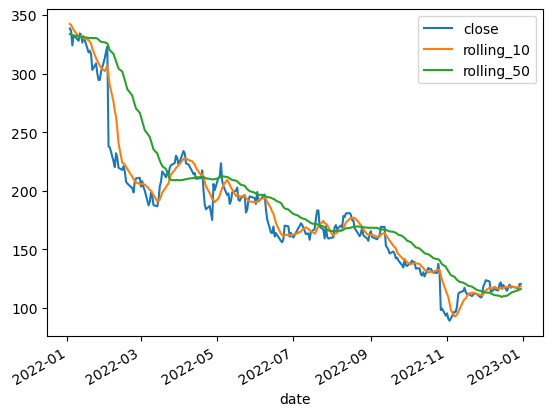

In [11]:
fb_2022 = fb.iloc[fb.index.year == 2022]

fb_2022[['close','rolling_10','rolling_50']].plot()

<Axes: xlabel='date'>

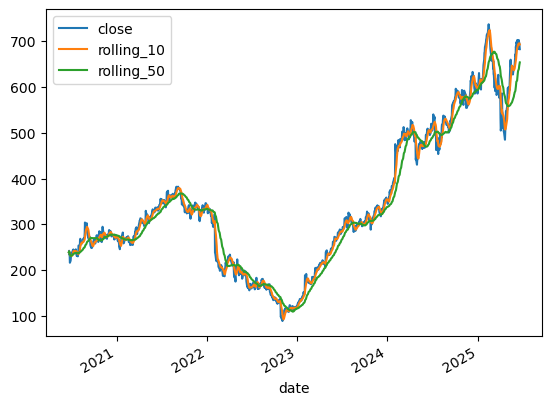

In [12]:
fb[['close','rolling_10','rolling_50']].plot()

In [23]:
#Trading Strategy:
#If rolling_10 > rolling_50 -> buy and hold (long)

fb['shares'] = [1 if fb.loc[ei,'rolling_10']>fb.loc[ei,'rolling_50'] else 0 for ei in fb.index]

In [27]:
fb['profit'] = [fb.shift(-1).loc[ei,'close']-fb.loc[ei,'close'] if fb.loc[ei,'shares'] else 0 for ei in fb.index]

In [29]:
fb['wealth'] = fb['profit'].cumsum()

<Axes: xlabel='date'>

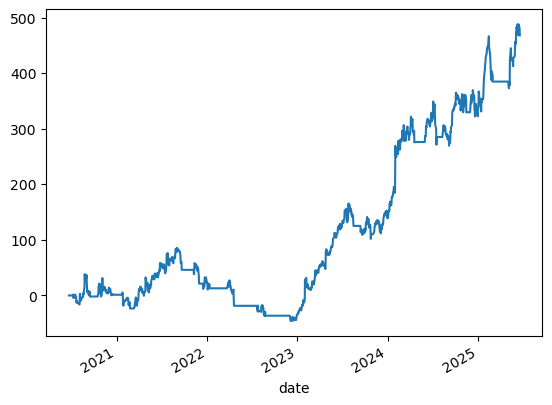

In [30]:
fb['wealth'].plot()

In [32]:
fb.columns

Index(['open', 'high', 'low', 'close', 'adjClose', 'volume',
       'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label',
       'changeOverTime', 'price_diff', 'daily_return', 'direction',
       'rolling_20', 'rolling_10', 'rolling_50', 'shares', 'profit', 'wealth'],
      dtype='object')